# Apresentação do notebook  

**Do projeto:**  Uma Investigação sobre a Evasão Escolar no Ensino Médio Brasileiro durante a Pandemia de Covid-19

**Objetivo:** Realização de análise multitemporal com os dados do ano-base de 2019 e 2020  


# 1\. Conhecendo o perfil das escolas analisadas

## Preparação dos dados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/Data Girls/Grace Hopper/entrega_final

In [ ]:
import pandas as pd
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'

In [ ]:
filepath = os.getcwd() + '/data/processed/dados_escolas_2019.csv'
df_escolas_2019 = pd.read_csv(filepath, encoding='cp1252')

In [ ]:
filepath = os.getcwd() + '/data/processed/dados_escolas_2020.csv'
df_escolas_2020 = pd.read_csv(filepath, encoding='cp1252')

In [ ]:
# Cria um único DataFrame
df_completo = pd.concat([df_escolas_2019, df_escolas_2020], ignore_index=True)

### Por rede de ensino

In [ ]:
# Agrupa por ano e tipo de dependência e conta quantas escolas tem em cada grupo
freq_abs = df_completo.groupby(["ANO", "TIPO_DEPENDENCIA"]).size()

# Calcula a frequência relativa por ano
freq_rel = df_completo.groupby("ANO")["TIPO_DEPENDENCIA"].value_counts(normalize=True)

# Junta tudo em um DataFrame
tabela_freq = pd.DataFrame({
    'Nº de escolas': freq_abs,
    '%': (freq_rel * 100).round(2)
}).reset_index()

# Renomeia as colunas
tabela_freq.columns = ["Ano", "Tipo de Rede", "Nº de Escolas", "%"]

# Cria uma pivot table
tabela_pivot = tabela_freq.pivot(index="Ano", columns="Tipo de Rede", values=["Nº de Escolas", "%"])
print(tabela_pivot.to_string())

             Nº de Escolas                %        
Tipo de Rede       Privada  Pública Privada Pública
Ano                                                
2019                8408.0  20452.0   29.13   70.87
2020                8433.0  20500.0   29.15   70.85


### Por localização (urbana/rural)

In [ ]:
# Agrupa por ano e tipo de dependência e conta quantas escolas tem em cada grupo
freq_abs = df_completo.groupby(["ANO", "TP_LOCALIZACAO"]).size()

# Calcula a frequência relativa por ano (normalize dentro de cada ano)
freq_rel = df_completo.groupby("ANO")["TP_LOCALIZACAO"].value_counts(normalize=True)

# Junta tudo em um DataFrame
tabela_freq = pd.DataFrame({
    'Nº de escolas': freq_abs,
    '%': (freq_rel * 100).round(2)
}).reset_index()

# Renomeia as colunas para ficar mais legível
tabela_freq.columns = ["Ano", "Tipo de Localização", "Nº de Escolas", "%"]

# Cria uma pivot table
tabela_pivot = tabela_freq.pivot(index="Ano", columns="Tipo de Localização", values=["Nº de Escolas", "%"])
print(tabela_pivot.to_string())

                    Nº de Escolas               %       
Tipo de Localização         Rural   Urbana  Rural Urbana
Ano                                                     
2019                       3040.0  25820.0  10.53  89.47
2020                       3095.0  25838.0  10.70  89.30


###  Por localizações diferenciadas

In [ ]:
colunas_localizacao = ['AR_NAO_DIFER', 'AR_ASSENTAMENTO', 'AR_INDIGENA', 'AR_REM_QUILOMBO']

# Lista para armazenar os resultados por ano
tabelas_localizacao = []

# Loop para calcular por ano
for ano in df_completo["ANO"].unique():
    dados_ano = df_completo[df_completo["ANO"] == ano]

    contagem = dados_ano[colunas_localizacao].sum()
    total_escolas = len(dados_ano)
    porcentagem = (contagem / total_escolas) * 100

    df_distribuicao = pd.DataFrame({
        'Ano': ano,
        'Número de Escolas': contagem,
        'Percentual (%)': porcentagem.round(2)
    })

    df_distribuicao["Localização"] = df_distribuicao.index
    tabelas_localizacao.append(df_distribuicao)

# Junta tudo em um único DataFrame
df_localizacao_multitemporal = pd.concat(tabelas_localizacao, ignore_index=True)

# Reorganiza as colunas
df_localizacao_multitemporal = df_localizacao_multitemporal[['Ano', 'Localização', 'Número de Escolas', 'Percentual (%)']]

# Ordena por ano e percentual
df_localizacao_multitemporal = df_localizacao_multitemporal.sort_values(by=['Ano', 'Percentual (%)'], ascending=[True, False])

# Cria uma pivot table
tabela_pivot_percentual = df_localizacao_multitemporal.pivot_table(
    index='Localização',
    columns='Ano',
    values=['Número de Escolas', 'Percentual (%)']
).round(2)

print(tabela_pivot_percentual.to_string())

                Número de Escolas          Percentual (%)       
Ano                          2019     2020           2019   2020
Localização                                                     
AR_ASSENTAMENTO             237.0    240.0           0.82   0.83
AR_INDIGENA                 474.0    486.0           1.64   1.68
AR_NAO_DIFER              28035.0  28095.0          97.14  97.10
AR_REM_QUILOMBO             114.0    112.0           0.40   0.39


# 2\. Análise da evasão escolar

## Taxas médias ponderadas de evasão

### Preparação dos dados

In [ ]:
import pandas as pd
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'

In [ ]:
filepath = os.getcwd() + '/data/processed/municipios_unicos_tev_2019.csv'
df_municipios_2019 = pd.read_csv(filepath, encoding='cp1252')

In [ ]:
filepath = os.getcwd() + '/data/processed/municipios_unicos_tev_2020.csv'
df_municipios_2020 = pd.read_csv(filepath, encoding='cp1252')

In [ ]:
df_completo_municipio = pd.concat([df_municipios_2019, df_municipios_2020], ignore_index=True)

# Transforma TEV_MED em percentual
df_completo_municipio['TEV_MED'] = df_completo_municipio['TEV_MED'] * 100

### Cálculo das métricas

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis

# Lista para armazenar os resultados
resultados = []

# Loop para cada ano
for ano in df_completo_municipio["ANO"].unique():
    dados_ano = df_completo_municipio[df_completo_municipio["ANO"] == ano]

    # Remove NAs apenas das colunas necessárias
    df_validos = dados_ano.dropna(subset=['TEV_MED', 'QT_MAT_MED'])

    # Média ponderada geral
    media_geral = (
        df_validos['TEV_MED'] * df_validos['QT_MAT_MED']
    ).sum() / df_validos['QT_MAT_MED'].sum()

    # Estatísticas descritivas
    mediana = df_validos['TEV_MED'].median()
    desvio_padrao = df_validos['TEV_MED'].std()
    iqr = df_validos['TEV_MED'].quantile(0.75) - df_validos['TEV_MED'].quantile(0.25)
    cv = (desvio_padrao / df_validos['TEV_MED'].mean()) * 100
    assimetria = skew(df_validos['TEV_MED'])
    curtose = kurtosis(df_validos['TEV_MED'], fisher=True)  # fisher=True para zerar a normal

    resultados.append({
        "Ano": ano,
        "Taxa Média Ponderada (%)": round(media_geral, 4),
        "Mediana (%)": round(mediana, 4),
        "Desvio Padrão": round(desvio_padrao, 4),
        "IQR": round(iqr, 4),
        "Coef. Variação (%)": round(cv, 2),
        "Assimetria": round(assimetria, 4),
        "Curtose": round(curtose, 4)
    })

df_resultados = pd.DataFrame(resultados)

print("Ensino Médio - Taxas de Evasão (%): Estatísticas  Descritivas 2019/2020")
print(df_resultados.round(2))

Ensino Médio - Taxas de Evasão (%): Estatísticas  Descritivas 2019/2020
    Ano  Taxa Média Ponderada (%)  Mediana (%)  Desvio Padrão  IQR  \
0  2019                      6.94         6.35           4.16  4.9   
1  2020                      5.88         5.50           5.13  6.5   

   Coef. Variação (%)  Assimetria  Curtose  
0               57.98        1.32     2.68  
1               78.16        1.72     7.59  


### Criação das visualizações

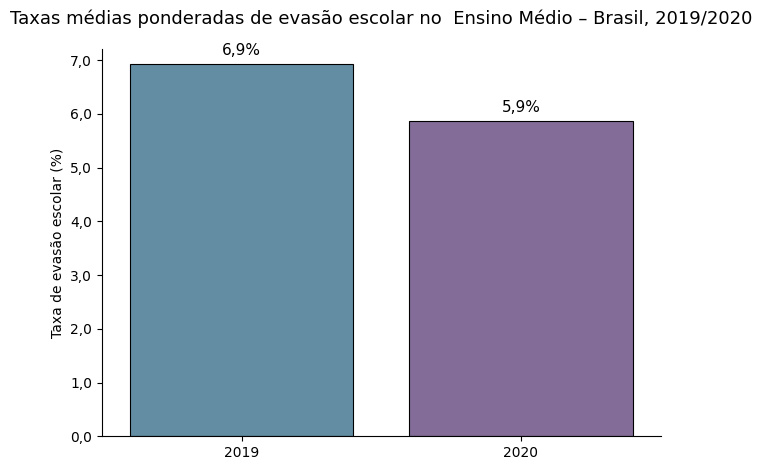

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

def formatar_decimal(x, _):
  return f"{x:.1f}".replace('.', ',')


cores = ['#5891ad', '#8464a0']

barplot = sns.barplot(
    data= df_resultados,
    x='Ano',
    y='Taxa Média Ponderada (%)',
    palette=cores,
    hue='Ano',
    edgecolor='black',
    linewidth=0.8,
    zorder=2,
    legend=False
)
sns.despine()

# Adiciona valores acima das barras
for container in barplot.containers:
    barplot.bar_label(
        container,
        labels=[f'{v:.1f}'.replace('.', ',') + '%' for v in container.datavalues],
        label_type='edge',
        padding=4,
        fontsize=11,
        color='black'
    )


plt.gca().yaxis.set_major_formatter(FuncFormatter(formatar_decimal))
plt.title('Taxas médias ponderadas de evasão escolar no  Ensino Médio – Brasil, 2019/2020', pad=18, fontsize=13, linespacing=1.8)
plt.xlabel('')
plt.ylabel('Taxa de evasão escolar (%)', fontsize=10, labelpad=4)
plt.ylim(0, 7.2)
plt.tight_layout()
plt.show()

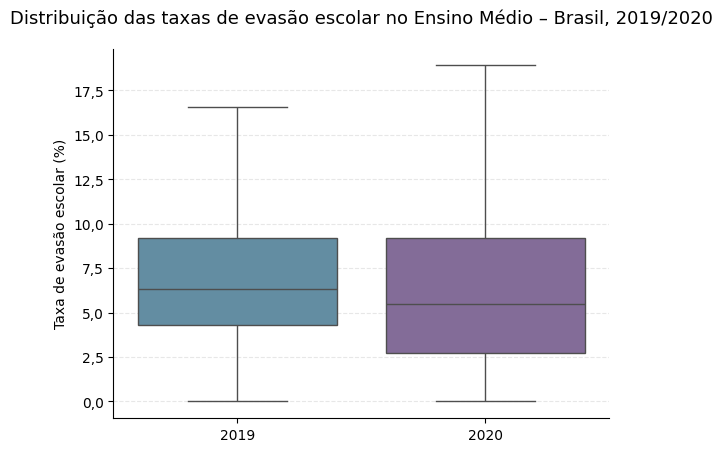

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

def formatar_decimal(x, _):
  return f"{x:.1f}".replace('.', ',')

cores = ['#5891ad', '#8464a0']

sns.boxplot(
    data=df_completo_municipio,
    x='ANO',
    y='TEV_MED',
    palette=cores,
    hue='ANO',
    showfliers=False,
    zorder=2,
    legend=False
)
sns.despine()

plt.gca().yaxis.set_major_formatter(FuncFormatter(formatar_decimal))
plt.xlabel('')
plt.ylabel('Taxa de evasão escolar (%)', fontsize=10, labelpad=4)
plt.title('Distribuição das taxas de evasão escolar no Ensino Médio – Brasil, 2019/2020', pad=18, fontsize=13, linespacing=1.7)
plt.grid(axis='y', linestyle='--', alpha=0.3, zorder=1)
plt.show()

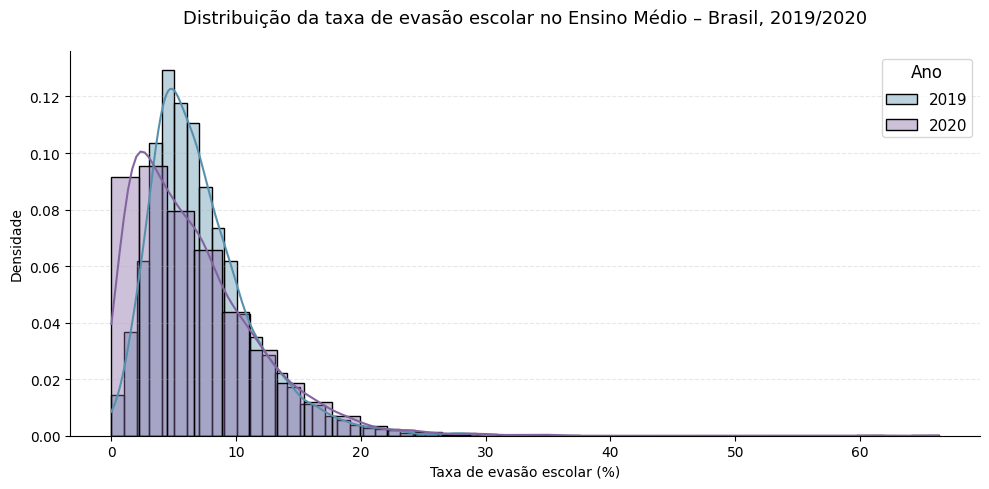

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

def formatar_decimal(x, _):
    return f"{x:.0f}".replace('.', ',')

cores = ['#5891ad', '#8464a0']
plt.figure(figsize=(10, 5))

# Histogramas com curva de densidade
for i, ano in enumerate([2019, 2020]):
    dados = df_completo_municipio[df_completo_municipio['ANO'] == ano]['TEV_MED'].dropna()
    sns.histplot(
        dados,
        kde=True,
        bins=30,
        color=cores[i],
        label=f"{ano}",
        stat="density",
        alpha=0.4,
        linewidth=1
    )
    sns.despine()

plt.xlabel('Taxa de evasão escolar (%)', fontsize=10)
plt.ylabel('Densidade', fontsize=10)
plt.title('Distribuição da taxa de evasão escolar no Ensino Médio – Brasil, 2019/2020', fontsize=13, pad=20)
plt.legend(title='Ano', loc='upper right', fontsize=11, title_fontsize='12',
          borderpad=0.3, labelspacing=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.gca().xaxis.set_major_formatter(FuncFormatter(formatar_decimal))
plt.tight_layout()
plt.show()

Investigação de outliers (escolas com taxas extremas de evasão)

In [ ]:
# Filtra outliers com evasão > 25%
outliers = df_completo_municipio[df_completo_municipio['TEV_MED'] > 25]
outliers[['NO_MUNICIPIO',  'ANO', 'QT_MAT_MED', 'TEV_MED', 'SG_UF', 'REDE_PUBLICA', 'REDE_PRIVADA', 'TEV_MED1', 'TEV_MED2', 'TEV_MED3']].sort_values(by='TEV_MED', ascending=False)

,NO_MUNICIPIO,ANO,QT_MAT_MED,TEV_MED,SG_UF,REDE_PUBLICA,REDE_PRIVADA,TEV_MED1,TEV_MED2,TEV_MED3
8477,Santana da Vargem,2020,302.0,66.300000,MG,1.0,0.0,0.7890,0.9770,0.2550
7721,Santa Inês,2020,953.0,61.267580,BA,2.0,0.0,0.5225,0.5105,0.0000
10598,Tapes,2020,372.0,35.500000,RS,1.0,0.0,0.3470,0.5130,0.1040
8465,Santa Cruz de Minas,2020,106.0,34.900000,MG,1.0,0.0,0.3270,0.5000,0.2080
7766,Taperoá,2020,386.0,34.800002,BA,1.0,0.0,0.4270,0.2700,0.0310
9759,Ramilândia,2020,174.0,34.800000,PR,1.0,0.0,0.4610,0.4120,0.1630
7555,Itabela,2020,910.0,33.200000,BA,1.0,0.0,0.0840,0.6540,0.0000
7207,Xexéu,2020,670.0,32.804480,PE,3.0,0.0,0.4020,0.0900,0.0220
10296,Dona Francisca,2020,69.0,32.800000,RS,1.0,0.0,0.3700,0.4490,0.0000
10319,Eugênio de Castro,2020,60.0,31.700000,RS,1.0,0.0,0.4550,0.2170,0.0000


## Taxas médias de evasão por estados

### Cálculo das métricas

In [ ]:
def calcular_media_ponderada(df, grupo, valor_col, peso_col):
    df = df.dropna(subset=[valor_col, peso_col]).copy()
    df['ponderador'] = df[valor_col] * df[peso_col]

    resultado = (
        df.groupby(grupo)
        .agg(
            evasao_ponderada=('ponderador', 'sum'),
            total_peso=(peso_col, 'sum')
        )
        .reset_index()
    )

    resultado['media_ponderada'] = resultado['evasao_ponderada'] / resultado['total_peso']
    return resultado

In [ ]:
df_estado_ano = calcular_media_ponderada(df_completo_municipio, ['SG_UF', 'ANO'], 'TEV_MED', 'QT_MAT_MED')
df_estado_ano

,SG_UF,ANO,evasao_ponderada,total_peso,media_ponderada
0,AC,2019,2.549675e+05,38116.0,6.689251
1,AC,2020,2.589969e+05,39287.0,6.592433
2,AL,2019,9.398870e+05,116193.0,8.089016
3,AL,2020,5.856256e+05,117488.0,4.984557
4,AM,2019,1.840898e+06,205128.0,8.974385
5,AM,2020,3.539613e+05,207688.0,1.704293
6,AP,2019,3.538344e+05,32987.0,10.726480
7,AP,2020,1.204970e+05,31639.0,3.808496
8,BA,2019,4.242765e+06,544868.0,7.786775
9,BA,2020,2.764321e+06,557441.0,4.958948


### Criação das visualizações

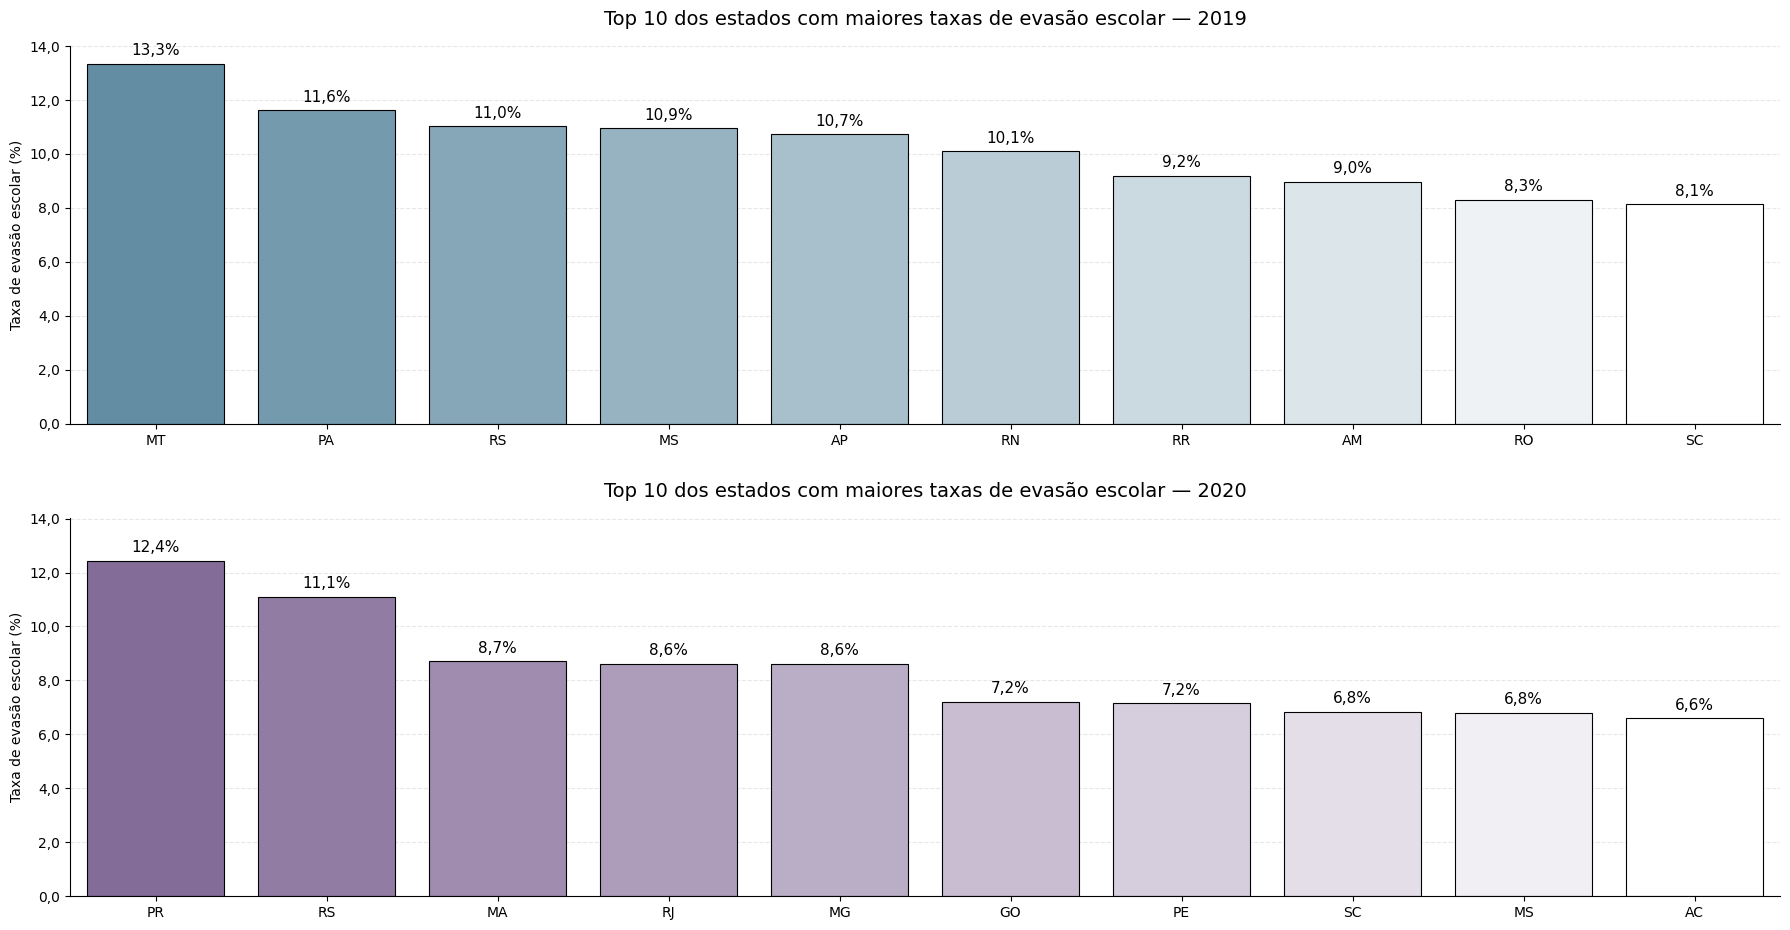

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import to_rgb

# Função para formatar eixo y com vírgula e 1 casa decimal
def formatar_decimal(x, _):
    return f"{x:.1f}".replace('.', ',')

# Função para gerar tons desvanecidos a partir de uma cor base
def gerar_tons_desvanecidos(cor_base_hex, n_tons):
    rgb_base = to_rgb(cor_base_hex)
    tons = [
        tuple([c + (1 - c) * (i / (n_tons - 1)) for c in rgb_base])
        for i in range(n_tons)
    ]
    return tons

# Lista de anos únicos
anos = sorted(df_estado_ano['ANO'].unique())

cores_ano = ['#5891ad', '#8464a0'][:len(anos)]

fig, axes = plt.subplots(len(anos), 1, figsize=(18, 5 * len(anos)), sharey=True)

if len(anos) == 1:
    axes = [axes]

for i, ano in enumerate(anos):
    ax = axes[i]

    # Filtra e ordena top 10 por TEV_MED_PONDERADA
    dados_ano = (
        df_estado_ano[df_estado_ano['ANO'] == ano]
        .sort_values(by='media_ponderada', ascending=False)
        .head(10)
    )

    # Gera tons desvanecidos
    ufs_top10 = dados_ano['SG_UF'].tolist()
    tons_desvanecidos = gerar_tons_desvanecidos(cores_ano[i], len(ufs_top10))
    mapa_cores = dict(zip(ufs_top10, tons_desvanecidos))

    # Gráfico de barras
    barplot = sns.barplot(
        data=dados_ano,
        x='SG_UF',
        y='media_ponderada',
        palette=mapa_cores,
        edgecolor='black',
        linewidth=0.8,
        ax=ax,
        zorder=2,
        hue='SG_UF',
        legend=False
    )

    # Rótulos
    for container in barplot.containers:
        barplot.bar_label(
            container,
            labels=[f'{v:.1f}'.replace('.', ',') + '%' for v in container.datavalues],
            label_type='edge',
            padding=4,
            fontsize=11,
            color='black',
        )

    ax.set_xlabel('')
    ax.set_ylabel('Taxa de evasão escolar (%)', fontsize=10, labelpad=4)
    ax.set_title(f'Top 10 dos estados com maiores taxas de evasão escolar — {ano}', fontsize=14, pad=15)
    ax.yaxis.set_major_formatter(FuncFormatter(formatar_decimal))
    ax.grid(axis='y', linestyle='--', alpha=0.3, zorder=1)
    sns.despine(ax=ax)

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.subplots_adjust(hspace=0.25)
plt.show()

## Taxas médias de evasão por região

### Cálculo das métricas

In [ ]:
df_regiao_ano = calcular_media_ponderada(df_completo_municipio, ['NO_REGIAO', 'ANO'], 'TEV_MED', 'QT_MAT_MED')
df_regiao_ano

,NO_REGIAO,ANO,evasao_ponderada,total_peso,media_ponderada
0,Centro-Oeste,2019,5.356093e+06,593504.0,9.024527
1,Centro-Oeste,2020,3.849134e+06,611088.0,6.298820
2,Nordeste,2019,1.472192e+07,2112466.0,6.969067
3,Nordeste,2020,1.154967e+07,2130375.0,5.421425
4,Norte,2019,7.693094e+06,781394.0,9.845346
5,Norte,2020,2.545895e+06,786136.0,3.238492
6,Sudeste,2019,1.600370e+07,2992471.0,5.347989
7,Sudeste,2020,1.557054e+07,2999693.0,5.190710
8,Sul,2019,8.023199e+06,986056.0,8.136656
9,Sul,2020,1.084831e+07,1023461.0,10.599636


### Criação das visualizações

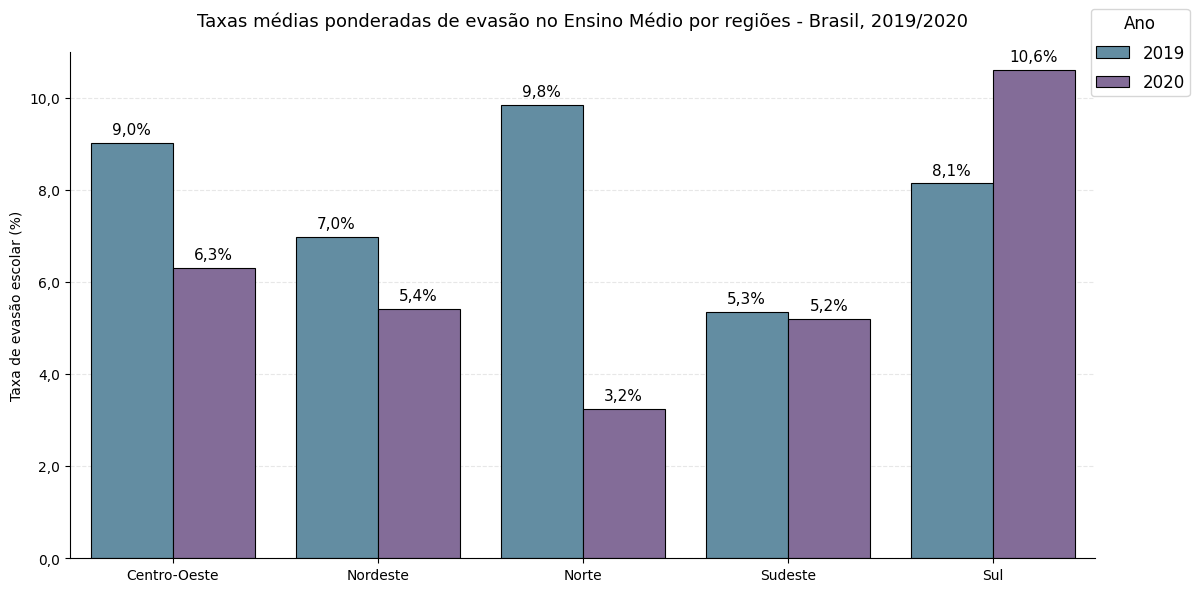

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def formatar_decimal(x, _):
    return f"{x:.1f}".replace('.', ',')

cores = ['#5891ad', '#8464a0']

plt.figure(figsize=(12, 6))
barplot = sns.barplot(
    data=df_regiao_ano,
    x='NO_REGIAO',
    y='media_ponderada',
    hue='ANO',
    palette=cores,
    edgecolor='black',
    linewidth=0.8,
    zorder=2
)
sns.despine()

for container in barplot.containers:
    barplot.bar_label(
        container,
        labels=[f'{v:.1f}'.replace('.', ',') + '%' for v in container.datavalues],
        label_type='edge',
        padding=4,
        fontsize=11,
        color='black'
)

plt.gca().yaxis.set_major_formatter(FuncFormatter(formatar_decimal))
plt.legend(title='Ano', loc='upper right', fontsize=12, bbox_to_anchor=(1.10,1.1), title_fontsize='12',
          borderpad=0.3, labelspacing=0.7)
plt.title('Taxas médias ponderadas de evasão no Ensino Médio por regiões - Brasil, 2019/2020', pad=18, fontsize=13, linespacing=1.7)
plt.xlabel('')
plt.ylabel('Taxa de evasão escolar (%)', fontsize=10, labelpad=4)
plt.grid(axis='y', linestyle='--', alpha=0.3, zorder=1)
plt.ylim(0, 11.)
plt.tight_layout()
plt.show()

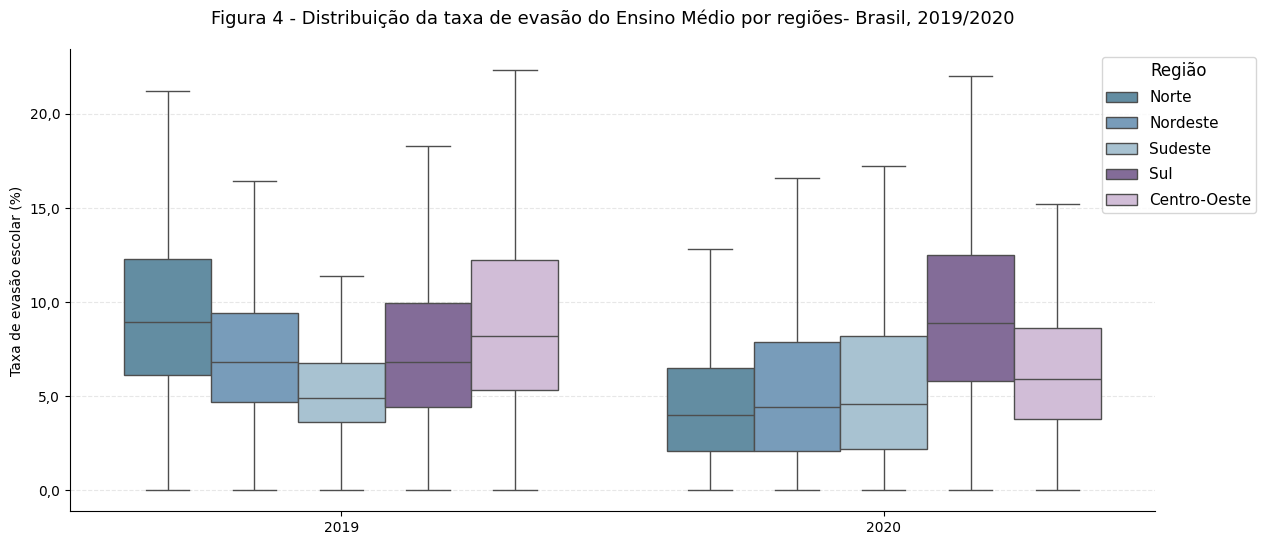

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

plt.figure(figsize=(14, 6))

cores = ['#5891ad', '#6d9dc5', '#a1c4d8', '#8464a0', '#d3b9db']

def formatar_decimal(x, _):
  return f"{x:.1f}".replace('.', ',')

sns.boxplot(
    data=df_completo_municipio,
    x='ANO',
    y='TEV_MED',
    palette=cores,
    hue='NO_REGIAO',
    showfliers=False,
    zorder=2
)
sns.despine()

plt.gca().yaxis.set_major_formatter(FuncFormatter(formatar_decimal))
plt.legend(title='Região', loc='upper right', fontsize=11, bbox_to_anchor=(1.10,1), title_fontsize='12',
          borderpad=0.3, labelspacing=0.7)
plt.title('Figura 4 - Distribuição da taxa de evasão do Ensino Médio por regiões- Brasil, 2019/2020', pad=18, fontsize=13, linespacing=1.7)
plt.xlabel('')
plt.ylabel('Taxa de evasão escolar (%)', fontsize=10, labelpad=4)
plt.grid(axis='y', linestyle='--', alpha=0.3, zorder=1)
plt.show()

## Taxas médias de evasão por rede de ensino

### Preparação dos dados

In [ ]:
filepath = os.getcwd() + '/data/processed/municipios_rede_tev_2019.csv'
df_municipios_rede_2019 = pd.read_csv(filepath, encoding='cp1252')

In [ ]:
filepath = os.getcwd() + '/data/processed/municipios_rede_tev_2020.csv'
df_municipios_rede_2020 = pd.read_csv(filepath, encoding='cp1252')

In [ ]:
df_completo_municipio_rede = pd.concat([df_municipios_rede_2019, df_municipios_rede_2020], ignore_index=True)

# Transforma TEV_MED em percentual
df_completo_municipio_rede['TEV_MED'] = df_completo_municipio_rede['TEV_MED'] * 100

### Cálculo das métricas

In [ ]:
import pandas as pd

# Cria coluna com o produto da taxa de evasão × número de matrículas
df_completo_municipio_rede['ponderador'] = df_completo_municipio_rede['TEV_MED'] * df_completo_municipio_rede['QT_MAT_MED']

# Agrupa por município e ano
df_rede = (
    df_completo_municipio_rede.groupby(['TP_DEPENDENCIA', 'ANO'])
    .agg(
        evasao_ponderada=('ponderador', 'sum'),
        total_matriculas=('QT_MAT_MED', 'sum')
    )
    .reset_index()
)

# Calcula a taxa média ponderada
df_rede['TEV_MED_PONDERADA'] = (
    df_rede['evasao_ponderada'] / df_rede['total_matriculas']
)
df_rede

,TP_DEPENDENCIA,ANO,evasao_ponderada,total_matriculas,TEV_MED_PONDERADA
0,Privada,2019,2817663.5,934393.0,3.015502
1,Privada,2020,2106921.4,925949.0,2.275418
2,Pública,2019,48985230.2,6531498.0,7.499846
3,Pública,2020,42288157.1,6624804.0,6.383307


### Criação das visualizações

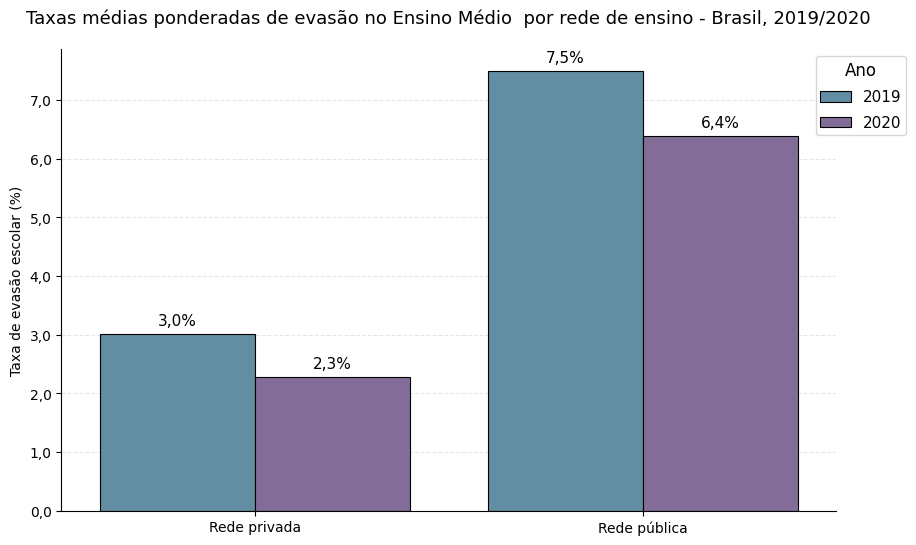

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def formatar_decimal(x, _):
  return f"{x:.1f}".replace('.', ',')

cores = ['#5891ad', '#8464a0']

plt.figure(figsize=(10, 6))

barplot = sns.barplot(
    data=df_rede,
    x='TP_DEPENDENCIA',
    y='TEV_MED_PONDERADA',
    hue='ANO',
    palette=cores,
    edgecolor='black',
    linewidth=0.8,
    zorder=2,
)
sns.despine()

for container in barplot.containers:
    barplot.bar_label(
        container,
        labels=[f'{v:.1f}'.replace('.', ',') + '%' for v in container.datavalues],
        label_type='edge',
        padding=4,
        fontsize=11,
        color='black'
)

plt.gca().yaxis.set_major_formatter(FuncFormatter(formatar_decimal))
plt.legend(title='Ano', loc='upper right', fontsize=11, bbox_to_anchor=(1.10,1.0), title_fontsize='12',
          borderpad=0.3, labelspacing=0.7)

plt.title('Taxas médias ponderadas de evasão no Ensino Médio  por rede de ensino - Brasil, 2019/2020', pad=18, fontsize=13, linespacing=1.7)
plt.xlabel('')
plt.ylabel('Taxa de evasão escolar (%)', fontsize=10, labelpad=4)
plt.xticks(['Privada', 'Pública'], ['Rede privada', 'Rede pública'])
plt.grid(axis='y', linestyle='--', alpha=0.3, zorder=1)
plt.show()

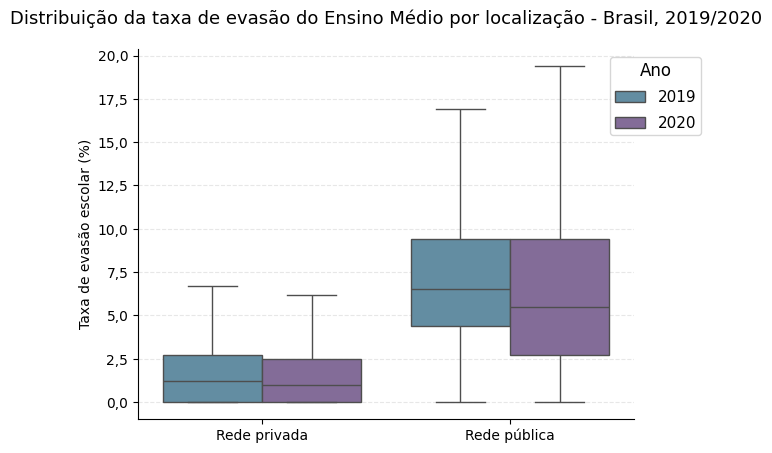

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

def formatar_decimal(x, _):
  return f"{x:.1f}".replace('.', ',')

cores = ['#5891ad', '#8464a0']

sns.boxplot(
    data=df_completo_municipio_rede,
    x='TP_DEPENDENCIA',
    y='TEV_MED',
    palette=cores,
    hue='ANO',
    showfliers=False,
    zorder=2,
    order=['Privada', 'Pública']
)
sns.despine()

plt.gca().yaxis.set_major_formatter(FuncFormatter(formatar_decimal))
plt.xlabel('')
plt.xticks(['Privada', 'Pública'], ['Rede privada', 'Rede pública'])
plt.ylabel('Taxa de evasão escolar (%)', fontsize=10, labelpad=4)
plt.legend(title='Ano', loc='upper right', fontsize=11, bbox_to_anchor=(1.15,1.0), title_fontsize='12',
          borderpad=0.3, labelspacing=0.7)
plt.title('Distribuição da taxa de evasão do Ensino Médio por localização - Brasil, 2019/2020', pad=18, fontsize=13, linespacing=1.7)
plt.grid(axis='y', linestyle='--', alpha=0.3, zorder=1)
plt.show()

## Taxas médias de evasão por localização

### Preparação dos dados

In [ ]:
filepath = os.getcwd() + '/data/processed/municipios_tev_2019.csv'
df_municipios_loc_2019 = pd.read_csv(filepath, encoding='cp1252')

In [ ]:
filepath = os.getcwd() + '/data/processed/municipios_tev_2020.csv'
df_municipios_loc_2020 = pd.read_csv(filepath, encoding='cp1252')

In [ ]:
# Cria um único DataFrame
df_completo_municipio_loc = pd.concat([df_municipios_loc_2019, df_municipios_loc_2020], ignore_index=True)

# Transforma TEV_MED em percentual
df_completo_municipio_loc['TEV_MED'] = df_completo_municipio_loc['TEV_MED'] * 100

### Cálculo das métricas

In [ ]:
import pandas as pd

# Cria coluna ponderadora (evasão × nº de matrículas)
df_completo_municipio_loc['ponderador'] = (
    df_completo_municipio_loc['TEV_MED'] *
    df_completo_municipio_loc['QT_MAT_MED']
)

# Agrupa por localização e ano
df_localizacao = (
    df_completo_municipio_loc
    .groupby(['TP_LOCALIZACAO', 'ANO'])
    .agg(
        evasao_ponderada=('ponderador', 'sum'),
        total_matriculas=('QT_MAT_MED', 'sum')
    )
    .reset_index()
)

# Calcula a média ponderada da taxa de evasão
df_localizacao['TEV_MED_PONDERADA'] = (
    df_localizacao['evasao_ponderada'] / df_localizacao['total_matriculas']
)
df_localizacao

,TP_LOCALIZACAO,ANO,evasao_ponderada,total_matriculas,TEV_MED_PONDERADA
0,Rural,2019,3264691.2,375762.0,8.688189
1,Rural,2020,2329474.0,389504.0,5.980616
2,Urbana,2019,48530286.0,7090129.0,6.844768
3,Urbana,2020,42031365.9,7161249.0,5.869279


In [ ]:
df_localizacao[['TP_LOCALIZACAO','TEV_MED_PONDERADA']]

,TP_LOCALIZACAO,TEV_MED_PONDERADA
0,Rural,8.688189
1,Rural,5.980616
2,Urbana,6.844768
3,Urbana,5.869279


### Criação das visualizações

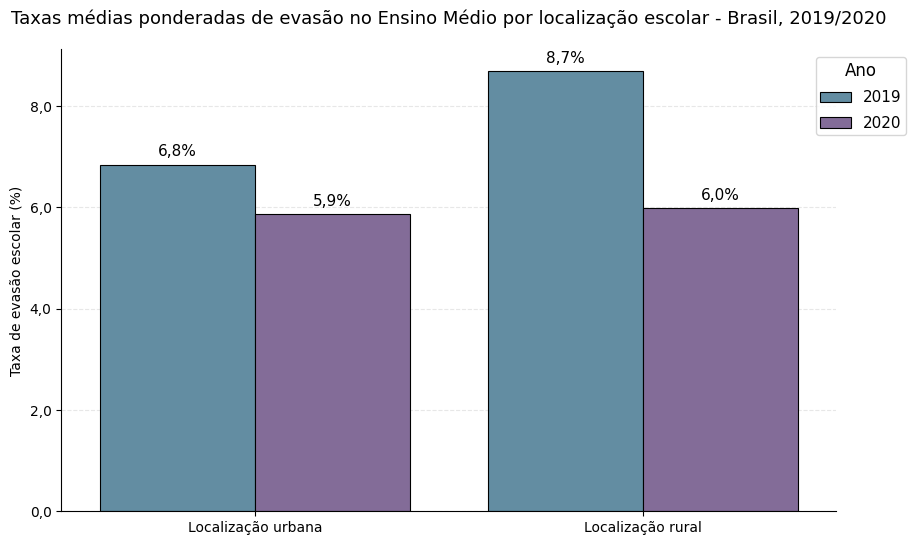

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def formatar_decimal(x, _):
  return f"{x:.1f}".replace('.', ',')

cores = ['#5891ad', '#8464a0']

plt.figure(figsize=(10, 6))

barplot = sns.barplot(
    data=df_localizacao,
    x='TP_LOCALIZACAO',
    y='TEV_MED_PONDERADA',
    hue='ANO',
    palette=cores,
    edgecolor='black',
    linewidth=0.8,
    zorder=2,
    order=['Urbana', 'Rural']
)
sns.despine()

for container in barplot.containers:
    barplot.bar_label(
        container,
        labels=[f'{v:.1f}'.replace('.', ',') + '%' for v in container.datavalues],
        label_type='edge',
        padding=4,
        fontsize=11,
        color='black'
)

plt.gca().yaxis.set_major_formatter(FuncFormatter(formatar_decimal))
plt.legend(title='Ano', loc='upper right', fontsize=11, bbox_to_anchor=(1.10,1.0), title_fontsize='12',
          borderpad=0.3, labelspacing=0.7)
plt.title('Taxas médias ponderadas de evasão no Ensino Médio por localização escolar - Brasil, 2019/2020', pad=18, fontsize=13, linespacing=1.7)
plt.xlabel('')
plt.ylabel('Taxa de evasão escolar (%)', fontsize=10, labelpad=4)
plt.xticks(['Rural', 'Urbana'], ['Localização rural', 'Localização urbana'])
plt.grid(axis='y', linestyle='--', alpha=0.3, zorder=1)
plt.show()

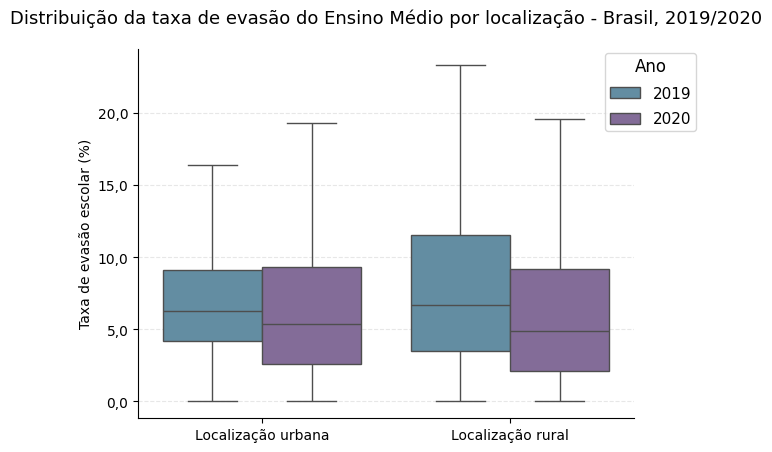

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

def formatar_decimal(x, _):
  return f"{x:.1f}".replace('.', ',')

cores = ['#5891ad', '#8464a0']

sns.boxplot(
    data=df_completo_municipio_loc,
    x='TP_LOCALIZACAO',
    y='TEV_MED',
    palette=cores,
    hue='ANO',
    showfliers=False,
    zorder=2,
)
sns.despine()

plt.gca().yaxis.set_major_formatter(FuncFormatter(formatar_decimal))
plt.xlabel('')
plt.xticks(['Rural', 'Urbana'], ['Localização rural', 'Localização urbana'])
plt.ylabel('Taxa de evasão escolar (%)', fontsize=10, labelpad=4)
plt.title('Distribuição da taxa de evasão do Ensino Médio por localização - Brasil, 2019/2020', pad=18, fontsize=13, linespacing=1.7)
plt.legend(title='Ano', loc='upper right', fontsize=11, bbox_to_anchor=(1.14,1.01), title_fontsize='12',
          borderpad=0.3, labelspacing=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.3, zorder=1)
plt.show()


# 3\. Aplicação dos testes estatísticos em hipóteses formuladas para este projeto


## Hipótese #1    

**Objetivo:**  
Verificar se houve diferença estatisticamente significativa entre as taxas de evasão do Ensino Médio nos anos de 2019 e 2020.  


**Formulação das hipóteses:**  
```
H₀ (nula): As distribuições das taxas de evasão em 2019 e 2020 são iguais.
H₁ (alternativa): As distribuições das taxas de evasão em 2019 e 2020 são diferentes.
```

**Teste aplicado:**  
 Teste U de Mann-Whitney

In [ ]:
from scipy.stats import mannwhitneyu

df_validos = df_completo_municipio.dropna(subset=['TEV_MED'])

evasao_2019 = df_validos[df_validos['ANO'] == 2019]['TEV_MED']
evasao_2020 = df_validos[df_validos['ANO'] == 2020]['TEV_MED']

In [ ]:
stat, p_valor = mannwhitneyu(evasao_2019, evasao_2020, alternative='two-sided')

print(f'Estatística do teste (U): {stat:.4f}')
print(f'Valor-p: {p_valor:.4f}')

Estatística do teste (U): 17590209.5000
Valor-p: 0.0000


In [ ]:
from scipy.stats import mannwhitneyu, norm
import numpy as np

evasao_2019 = df_validos[df_validos['ANO'] == 2019]['TEV_MED']
evasao_2020 = df_validos[df_validos['ANO'] == 2020]['TEV_MED']

n1 = len(evasao_2019)
n2 = len(evasao_2020)

# Mann-Whitney U
u_stat, p_valor = mannwhitneyu(evasao_2019, evasao_2020, alternative='two-sided')

# Cálculo da média e desvio padrão do U
u_mean = n1 * n2 / 2
u_std = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)

# Z-score
z = (u_stat - u_mean) / u_std

# Tamanho do efeito
r = abs(z) / np.sqrt(n1 + n2)

print(f"Estatística do teste (U): {u_stat:.4f}")
print(f"Valor-p: {p_valor:.4f}")
print(f"Estatística Z: {z:.4f}")
print(f"Tamanho do efeito r: {r:.4f}")

if r < 0.1:
    interpretacao = "Desprezível"
elif r < 0.3:
    interpretacao = "Pequena"
elif r < 0.5:
    interpretacao = "Média"
else:
    interpretacao = "Grande"

print(f"Magnitude: {interpretacao.capitalize()}")

Estatística do teste (U): 17590209.5000
Valor-p: 0.0000
Estatística Z: 12.5680
Tamanho do efeito r: 0.1192
Magnitude: Pequena


Resultados:

- O teste de Mann-Whitney U foi aplicado para verificar se houve diferença nas distribuições das taxas de evasão escolar no Ensino Médio entre os anos de 2019 e 2020.   

- O resultado indicou diferença estatisticamente significativa entre os dois anos (U = 17.590.209,5; p < 0,0001), sugerindo que os valores observados em 2020 tendem a diferir daqueles registrados em 2019. Ou seja: a hipótese nula é rejeitada.

- No entanto, o tamanho do efeito calculado (r = 0,12) foi pequeno, indicando que a magnitude dessa diferença é discreta. Isso sugere que, apesar de variações pontuais, a distribuição das taxas de evasão mudou um pouco e a maioria dos municípios manteve níveis semelhantes nos dois anos.

## Hipótese #2  

**Objetivo:**    
Verificar se houve diferença estatisticamente significativa entre as taxas de evasão do Ensino Médio entre escolas públicas e privadas nos anos de 2019 e 2020.    


**Formulação das hipóteses:**  
```
H₀ (nula): As distribuições das taxas de evasão das escolas públicas e privadas em 2019 e 2020 são iguais.
H₁ (alternativa): As distribuições das taxas de evasão das escolas públicas e privadas em 2019 e 2020 são diferentes.
```

**Teste aplicado:**  
 Teste U de Mann-Whitney


In [ ]:
import numpy as np

df_validos = df_completo_municipio_rede.dropna(subset=['TEV_MED', 'TP_DEPENDENCIA'])

for ano in df_validos['ANO'].unique():
    df_ano = df_validos[df_validos['ANO'] == ano]
    evasao_publica = df_ano.loc[df_ano['TP_DEPENDENCIA'] == 'Pública', 'TEV_MED']
    evasao_privada = df_ano.loc[df_ano['TP_DEPENDENCIA'] == 'Privada', 'TEV_MED']

    n1 = len(evasao_publica)
    n2 = len(evasao_privada)

    stat, p_valor = mannwhitneyu(evasao_publica, evasao_privada, alternative='two-sided')

    mu_U = n1 * n2 / 2
    sigma_U = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)

    Z = (stat - mu_U) / sigma_U
    r = abs(Z) / np.sqrt(n1 + n2)

    if r < 0.1:
        efeito = "Desprezível"
    elif r < 0.3:
        efeito = "Pequena"
    elif r < 0.5:
        efeito = "Média"
    else:
        efeito = "Grande"

    print(f"Ano: {ano}")
    print(f"Estatística do teste (U): {stat:.4f}")
    print(f"Valor-p: {p_valor:.4f}")
    print(f"Estatística Z: {Z:.4f}")
    print(f"Tamanho do efeito r: {r:.4f}")
    print(f"Magnitude: {efeito}\n")

Ano: 2019
Estatística do teste (U): 7742148.0000
Valor-p: 0.0000
Estatística Z: 47.7345
Tamanho do efeito r: 0.5659
Magnitude: Grande

Ano: 2020
Estatística do teste (U): 7240032.0000
Valor-p: 0.0000
Estatística Z: 40.6136
Tamanho do efeito r: 0.4814
Magnitude: Média



Resultados:
- Os testes Mann-Whitney U mostram que, tanto em 2019 quanto em 2020, as taxas médias ponderadas de evasão entre escolas públicas e privadas foram estatisticamente significativas (valor-p = 0.0000). Ou seja, a diferença observada dificilmente foi por acaso.

- Em 2019, o tamanho do efeito foi grande (r ≈ 0.57), sugerindo que a evasão nas escolas públicas era substancialmente diferente em relação às escolas privadas.

- Em 2020, o efeito foi médio (r ≈ 0.48), indicando que a diferença ainda era relevante, porém um pouco menor comparado a 2019.
    
- Essa redução no tamanho do efeito de 2019 para 2020 pode indicar que, mesmo com a pandemia e outras dificuldades, a diferença entre os dois tipos de escolas diminuiu um pouco, talvez como efeito das políticas públicas da época com a finalidade de minimizar a evasão em tempos de pandemia.


## Hipótese #3  

**Objetivo:**    
Verificar se houve diferença estatisticamente significativa entre as taxas de evasão do Ensino Médio entre escolas em localização rural e localização urbana nos anos de 2019 e 2020.  

**Formulação das hipóteses:**  
```
H₀ (nula): As distribuições das taxas de evasão das escolas em localização rural e urbana em 2019 e 2020 são iguais.  
H₁ (alternativa): As distribuições das taxas de evasão das escolas em localização rural e urbana em 2019 e 2020 são diferentes.
```

**Teste aplicado:**  
 Teste U de Mann-Whitney


In [ ]:
import numpy as np

df_validos = df_completo_municipio_loc.dropna(subset=['TEV_MED', 'TP_LOCALIZACAO'])

for ano in df_validos['ANO'].unique():
    df_ano = df_validos[df_validos['ANO'] == ano]
    evasao_urbana = df_ano.loc[df_ano['TP_LOCALIZACAO'] == 'Urbana', 'TEV_MED']
    evasao_rural = df_ano.loc[df_ano['TP_LOCALIZACAO'] == 'Rural', 'TEV_MED']

    n1 = len(evasao_urbana)
    n2 = len(evasao_rural)

    stat, p_valor = mannwhitneyu(evasao_urbana, evasao_rural, alternative='two-sided')

    mu_U = n1 * n2 / 2
    sigma_U = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)

    Z = (stat - mu_U) / sigma_U
    r = abs(Z) / np.sqrt(n1 + n2)

    if r < 0.1:
        efeito = "Desprezível"
    elif r < 0.3:
        efeito = "Pequena"
    elif r < 0.5:
        efeito = "Média"
    else:
        efeito = "Grande"

    print(f"Ano: {ano}")
    print(f"Estatística do teste (U): {stat:.4f}")
    print(f"Valor-p: {p_valor:.4f}")
    print(f"Estatística Z: {Z:.4f}")
    print(f"Tamanho do efeito r: {r:.4f}")
    print(f"Magnitude: {efeito}\n")

Ano: 2019
Estatística do teste (U): 3941185.0000
Valor-p: 0.0210
Estatística Z: -2.3078
Tamanho do efeito r: 0.0275
Magnitude: Desprezível

Ano: 2020
Estatística do teste (U): 4385280.0000
Valor-p: 0.0014
Estatística Z: 3.1934
Tamanho do efeito r: 0.0380
Magnitude: Desprezível



Resultados:
- Os testes Mann-Whitney U mostram que, tanto em 2019 quanto em 2020, foi identificada uma diferença estatisticamente significativa nas distribuições das taxas de evasão entre escolas localizadas em áreas urbanas e rurais.

- No entanto, os tamanhos do efeito observados foram desprezíveis (r < 0,04), indicando que, na prática, essa diferença é mínima. Ou seja, as distribuições de evasão rural e urbana são ligeiramente diferentes, mas a diferença prática é mínima, indicando padrões de evasão semelhantes entre os dois contextos, inclusive durante a pandemia (ao contrário do que poderia se supor diante das desigualdades estruturais entre campo e cidade).

